# Linear regression

Linear regression is a fundamental technique in statistical modeling for analyzing the relationship between a dependent variable (target) and one or more independent variables (features). Mathematically, it can be expressed as follows:

Given a dataset with $N$ observations and $p$ features, the goal of linear regression is to find the coefficients $\beta$ that minimize the residual sum of squares (RSS):
$$ RSS = Σ_{i=1}^{N} (y_i - (\beta x_i))^2 $$

The linear regression model assumes a linear relationship between the features and the target:
$$ y_i = \beta x_i + ε_i $$
Where $ε_i$ represents the error term. 

## Imports

In [266]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.linalg import lu, cholesky

## Load dataset

This project focuses on predicting medical costs using data science techniques, with a primary emphasis on linear regression. By analyzing a dataset containing features such as age, BMI, and smoking habits, we aim to create a predictive model that estimates medical expenses accurately. 

The medical costs dataset can be found [here](https://www.kaggle.com/datasets/nanditapore/medical-cost-dataset/discussion?resource=download). 

In [267]:
df = pd.read_csv('medical_cost.csv')
df.head()

,Id,age,sex,bmi,children,smoker,region,charges
0,1,19,female,27.900,0,yes,southwest,16884.92400
1,2,18,male,33.770,1,no,southeast,1725.55230
2,3,28,male,33.000,3,no,southeast,4449.46200
3,4,33,male,22.705,0,no,northwest,21984.47061
4,5,32,male,28.880,0,no,northwest,3866.85520


First, we need to convert the categorical values (yes/no, female/male, etc.) to numerical values (1/0 etc.). 

In [268]:
print('Unique values for column \'sex\':', df['sex'].unique())
print('Unique values for column \'smoker\':', df['smoker'].unique())
print('Unique values for column \'region\':', df['region'].unique())

Unique values for column 'sex': ['female' 'male']
Unique values for column 'smoker': ['yes' 'no']
Unique values for column 'region': ['southwest' 'southeast' 'northwest' 'northeast']


The two first features ('sex' and 'smoker') are binary, so we can convert them to 0/1. 
The third ('region') has four values without any oridnal relationship among them, and we therefore use one-hot-encoding. 

In [269]:
df['sex'] = df['sex'].map({'female': 1, 'male': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df = pd.get_dummies(df, columns=['region'], prefix=['region'])
df.head()

,Id,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,1,19,1,27.900,0,1,16884.92400,0,0,0,1
1,2,18,0,33.770,1,0,1725.55230,0,0,1,0
2,3,28,0,33.000,3,0,4449.46200,0,0,1,0
3,4,33,0,22.705,0,0,21984.47061,0,1,0,0
4,5,32,0,28.880,0,0,3866.85520,0,1,0,0


Then we create a correlation matrix of all features and the target. 

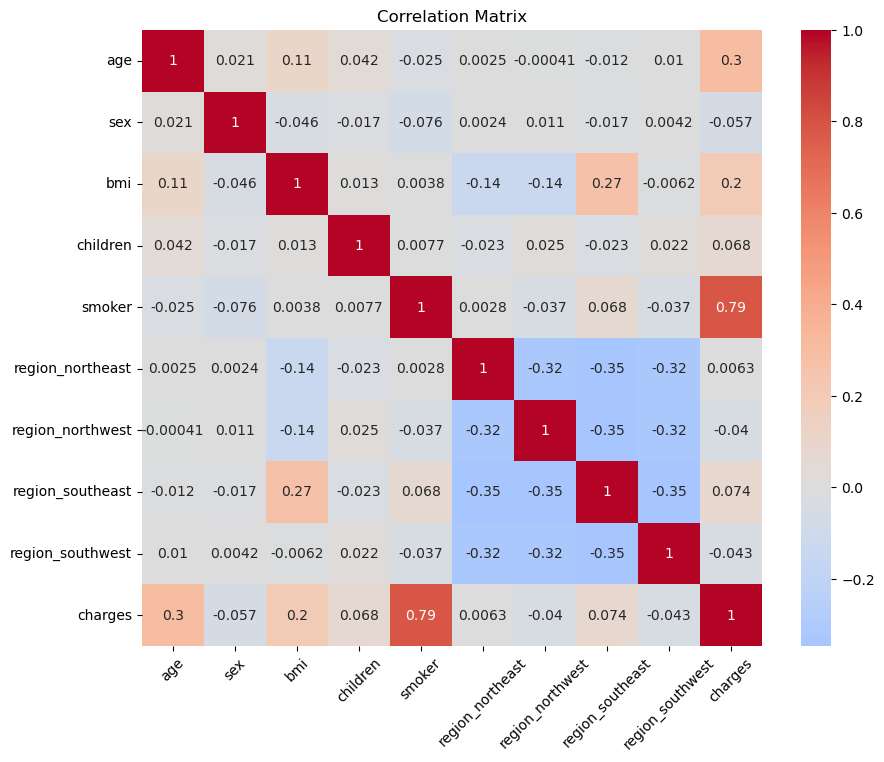

In [270]:
selected_features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'charges']
subset_df = df[selected_features]
correlation_matrix = subset_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

We want to predict charges, and see that the features 'age', 'bmi', and 'smoker' are its most correlated features. Therefore, we use those three features for our linear regression model. 

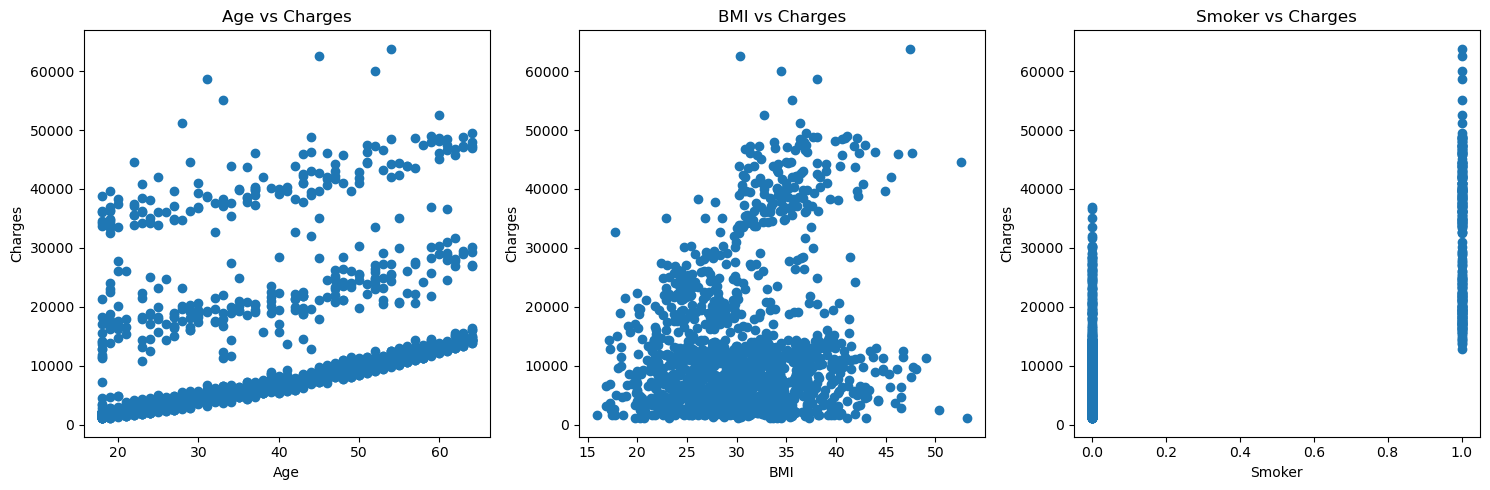

In [271]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(df['age'], df['charges'])
axes[0].set_title('Age vs Charges')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Charges')

axes[1].scatter(df['bmi'], df['charges'])
axes[1].set_title('BMI vs Charges')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Charges')

axes[2].scatter(df['smoker'], df['charges'])
axes[2].set_title('Smoker vs Charges')
axes[2].set_xlabel('Smoker')
axes[2].set_ylabel('Charges')

plt.tight_layout()
plt.show()

Then, we extract the features (age, bmi, smoker)...

In [272]:
features = ['age', 'bmi', 'smoker']
X = df[features].values

... and the target (charges) from the dataframe.

In [273]:
y = df['charges'].values

Normalizing input features is important in linear regression to ensure that features with different scales do not disproportionately influence the model's coefficients, leading to biased predictions and inaccurate interpretations of feature importance.

In [274]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

Add a column of ones for the intercept

In [275]:
X = np.hstack([np.ones((X.shape[0], 1)), X])

Then we split into train and test sets. 

In [276]:
n = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:n], X[n:], y[:n], y[n:]

## Model

Now we have an input vector $X^\top = (X_1, X_2, X_3)$ and want to predict $y$. The linear regression model has the form: 
$$ f(X) = \beta_0 + \sum_{j=1}^p X_j \beta_j $$

The most popular method for estimating the coefficients $\beta$ is least squares, where we minimize the residuals sum-of-squares: 
$$ RSS(\beta) = \sum_{i=1}^N (y_i-f(x_i))^2 = (y-X\beta)^\top (y-X\beta) $$

This is a quadratic function in the 4 (3 + intercept) parameters in our data. Differentiating with respect to $\beta$ gives:
$$ \dfrac{\partial RSS}{\partial \beta} = -2X^\top (y-X\beta) $$
$$ \dfrac{\partial^2 RSS}{\partial \beta \partial \beta^\top} =  2X^\top X $$

We assume that $X$ has a full column rank (and hence $X^\top X$ is positive definite) and set the first derivative to zero:
$$ X^\top (y-X\beta) = 0 $$

To obtain a unique solution:
$$ \hat{\beta} = (X^\top X)^{-1} X^\top y $$


In [277]:
beta_hat = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

Displaying the model coefficients and intercept helps us understand the specific impact of each input feature on the predicted output and provides insight into the baseline prediction when all input features are zero.

In [278]:
print("Intercept:", beta_hat[0])
print("Coefficients:", beta_hat[1:])

Intercept: 13176.174703422823
Coefficients: [3676.48803975 1973.93440851 9531.53178018]


The predicted values are given by $ \hat{y} = X \hat{\beta} = X(X^\top X)^{-1} X^\top y$

In [279]:
y_pred = X_test @ beta_hat

## Performance

Finally, we can display the performance of the model. First, we evaluate 
The model is evaluated using the root mean squared error defined as

$$ RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 } $$

where $n$ is the number of data points, $y_i$ represents the target value for the $i$-th data point, and $\hat{y}_i$ represents the predicted target value for the $i$-th data point. 



In [280]:
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print("RMSE:", rmse)

RMSE: 6123.817615546381


The coefficient of determination, commonly known as R-squared, is a statistical measure that indicates the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features) in a regression model.
The formula for R-squared is given by:

$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

where $SS_{res}$ is the sum of squares of residuals (the sum of squared differences between the actual and predicted values) and $SS_{tot}$ is the total sum of squares (the sum of squared differences between the actual values and the mean of the actual values). 

Specifically, R-squared measures the goodness-of-fit of the model to the actual data points. It ranges between 0 and 1, where:
* An R-squared value of 0 indicates that the model does not explain any of the variability in the target variable.
* An R-squared value of 1 indicates that the model perfectly explains the variability in the target variable.

In [281]:
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
print("R-squared:", r2)

R-squared: 0.7563721013596156


Variance covariance matrix is given by

$$ Var(\hat{\beta}) = (X^\top X)^{-1} \sigma^2 $$

where $\sigma^2$ is typically estimated using 
$$ \hat{\sigma}^2 = \dfrac{1}{N-p-1} \sum_{i=1}^N (y_i - \hat{y}_i)^2 $$
The $N-p-1$ in the denominator makes $\hat{\sigma}^2$ an unbiased estimate of $\sigma^2$.

In [314]:
np.linalg.inv(X_test.T @ X_test) * (1/(X_test.shape[0]-X_test.shape[1])) * np.sum((y_test - y_pred)**2)

array([[144382.08141501,  13757.51232684,  10323.22918638,
         -4655.14939862],
       [ 13757.51232684, 153330.73633641, -10593.16281368,
         11128.85012631],
       [ 10323.22918638, -10593.16281368, 141549.82582802,
         -7303.38900154],
       [ -4655.14939862,  11128.85012631,  -7303.38900154,
        135849.50404927]])

## Ridge

Ridge regression shrinks the regression coefficients by imposing a penalty on their size.

The goal of Ridge Regression is to find the coefficients $\beta$ that minimize the penalized residual sum of squares (RSS) along with the L2 regularization term:
$$ RSS(\lambda) = (y-X\beta)^\top (y-X\beta)+\lambda \beta^\top \beta $$

The ridge regression solution is given by: 
$$ \hat{\beta}^{ridge} = (X^\top X + \lambda I)^{-1} X\top y $$
where $I$ is the $p\times p$ identity matrix. 

$\lambda \geq 0$ is a parameter that controls the ammount of shrinkage. The larger the value of $\lambda$, the greater the amount of shrinkage. 

In [282]:
lambd = 1

In [283]:
beta_hat = np.linalg.inv(X_train.T @ X_train + lambd * np.eye(X_train.shape[1])) @ X_train.T @ y_train

In [284]:
print("Intercept:", beta_hat[0])
print("Coefficients:", beta_hat[1:])

Intercept: 13163.884758683787
Coefficients: [3673.44181518 1972.62336135 9522.34134845]


... and make predictions. 

In [285]:
y_pred = X_test @ beta_hat

In [286]:
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print("RMSE:", rmse)

RMSE: 6125.308847768914


## Residuals

Residual analysis involves examining the patterns and distributions of the model's residuals to ensure the underlying assumptions of linear regression are met and to identify any potential issues with the model's fit.

In [287]:
residuals = y_test - y_pred

* Residuals vs. Fitted Plot: This plot displays the relationship between the predicted values and the residuals. It helps us identify if there is any pattern in the residuals, which could indicate non-linearity or heteroscedasticity in the model.

* Residuals Distribution Plot: This histogram shows the distribution of residuals. By examining the shape and spread of the histogram, we can check whether the residuals are approximately normally distributed.

* Residuals Q-Q Plot: The quantile-quantile (Q-Q) plot compares the distribution of residuals against a theoretical normal distribution. If the points lie close to the diagonal line, it suggests that the residuals follow a normal distribution, which is an assumption of linear regression.

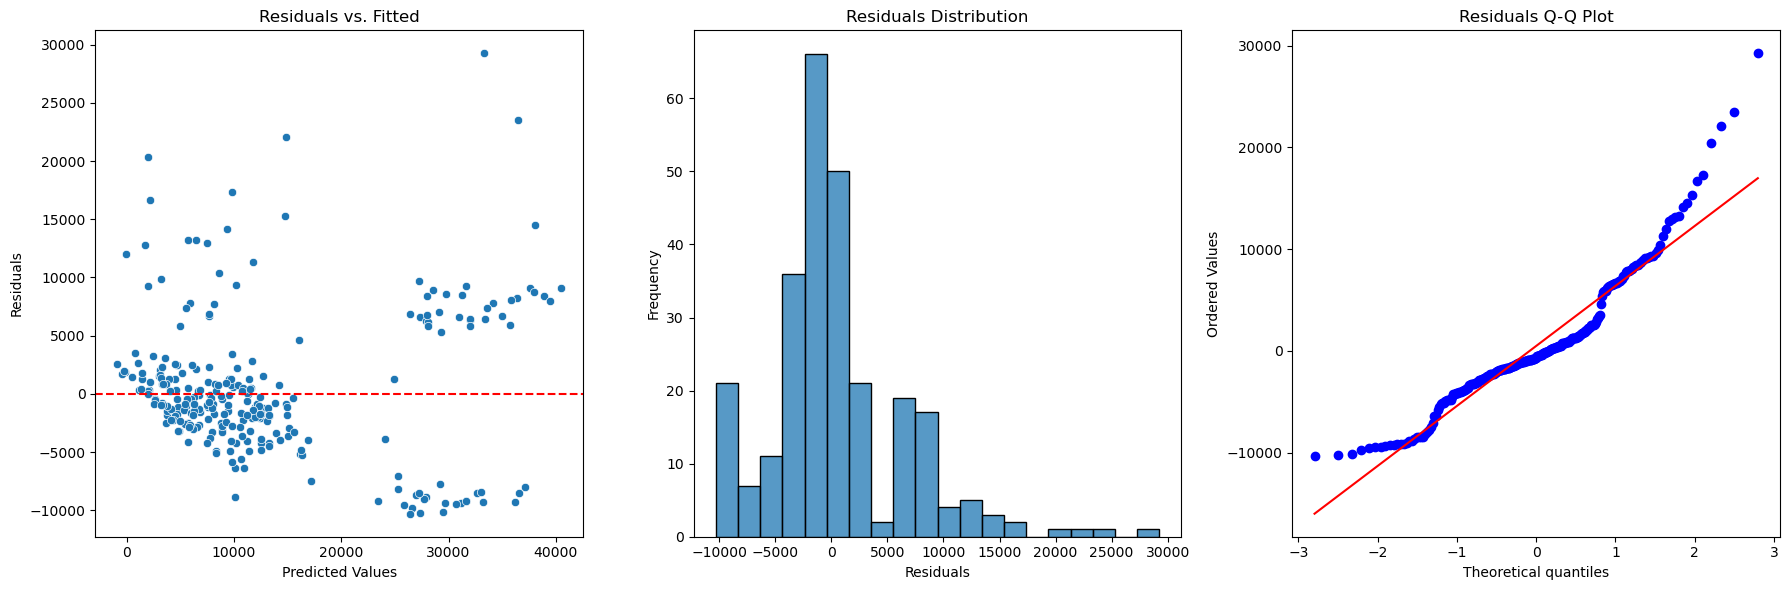

In [288]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 3, 2)
sns.histplot(residuals, bins=20)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
stats.probplot(residuals, plot=plt)
plt.title('Residuals Q-Q Plot')

plt.tight_layout()
plt.show()

## QR-decomposition

We can also solve the linear least squares regression problem using a trick form linear algebra: QR decomposition. 

**QR decomposition** says that for each non-singular $n\times n$ matrix $A$, there is a unique pair of orthogonal matrix $Q$ and upper-triangular matrix $R$ with positive diagonal elements such that $A=QR$. 

QR decomposition simplifies the process of solving linear systems and provides a more stable and accurate numerical solution. 
It is often used to solve linear systems $Ax=b$ where $A$ is a non-singular matrix. Since $Q$ is an orthogonal matrix, $Q^{-1}=Q^T$ and $QRx = b \Rightarrow Rx=Q^T b$. Since $R$ is an upper-triangular matrix, we can begin with $x_n$ (the equation is simply $R_{n,n}x_n = (Q^T b)_n$), and recursively calculate all $x_i$, $\forall i = n, n-1, ..., 1$. 

Linear regression with $n$ observations can be expressed as 

$$ y_i = \beta_0 x_{i,0} + \beta_1 x_{i,1} + ... + \beta_{p-1} x_{i,p-1} + \epsilon_i $$

$\forall i = 1,...,n$ where $x_{i,0}=1$, $\forall i$ is the intercept term and $x_{i,1},...,x_{i,p-1}$ are $p-1$ exogenous regressors. 
The goal is to find a set of weights $\beta$ that minimizes the squared error $\sum_{i=1}^n \epsilon_i^2$. In matrix form the problem becomes

$$ \min_{\beta} f(\beta) = \min_{\beta} \sum_{i=1}^n \epsilon_i^2 = \min_{\beta} (Y-X\beta)^T(Y-X\beta) $$
where $Y,\epsilon$ are $n\times 1$ column vectors and $X$ is a $n\times p$ matrix with each column representing a regressor and each row representing an observation. 

To mimimize $f(\beta)$ we take the first derivative with respect to $\beta$: $f´(\beta)=2X^T (Y-X\hat{\beta}=0 \Rightarrow (X^T X)\hat{\beta}=X^T Y$ where $(X^T X)$ is a $p\times p$ symmetrix matrix and $X^T Y$ is a $p \times 1$ column vector. 

Let $A=(X^T X), b=X^T Y$ and the problem becomes $A\hat{\beta}=b$ which can be solved using QR decomposition. 

In [289]:
Q, R = np.linalg.qr(X_train)

Solve the linear system $Ax = b$ by using the QR decompositionand rewriting it as $QRx = b$ and since Q is orthogonal and $Q^{-1} = Q^T$, we can rewrite it as $Rx = Q^T b$.

In [290]:
beta_hat = np.linalg.solve(R, Q.T @ y_train)

In [291]:
print("Intercept:", beta_hat[0])
print("Coefficients:", beta_hat[1:])

Intercept: 13176.174703422821
Coefficients: [3676.48803975 1973.93440851 9531.53178018]


In [292]:
y_pred = X_test @ beta_hat

In [293]:
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print("RMSE:", rmse)

RMSE: 6123.817615546382


## LU decomposition and Cholesky decomposition

Let $A$ be a non-singular $n \times n$ matrix. **LU decomposition** expresses $A$ as the product of a lower and upper triangular matrix: $A=LU$. LU decomposition can, like QR decomposition, be used to solve $Ax=b$. 


In [294]:
P, L, U = lu(X_train.T @ X_train)

In [295]:
beta_hat = np.linalg.solve(U, np.linalg.solve(L, X_train.T @ y_train))

In [296]:
print("Intercept:", beta_hat[0])
print("Coefficients:", beta_hat[1:])

Intercept: 13176.17470342282
Coefficients: [3676.48803975 1973.93440851 9531.53178018]


In [297]:
y_pred = X_test @ beta_hat

In [298]:
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print("RMSE:", rmse)

RMSE: 6123.817615546382


When $A$ is a symmetric positive definite matrix, **Cholesky decomposition** expresses $A$ as $A=R^T R$, where $R$ is a unique upper-triangular matrix with positive diagonal entries. Essentially, it is a LU decomposition with the property $L=U^T$. 
Cholesky decomposition is useful in Monte Carlo simulation to generate correlated random variables. 

In [299]:
L = cholesky(X_train.T @ X_train, lower=True)

In [300]:
beta_hat = np.linalg.solve(L.T, np.linalg.solve(L, X_train.T @ y_train))

In [301]:
print("Intercept:", beta_hat[0])
print("Coefficients:", beta_hat[1:])

Intercept: 13176.174703422821
Coefficients: [3676.48803975 1973.93440851 9531.53178018]


In [302]:
y_pred = X_test @ beta_hat

In [303]:
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print("RMSE:", rmse)

RMSE: 6123.817615546382


**Singular Value Decomposition (SVD)**: for any $n \times p$ matrix $X$, there exists a factorization of the form $X=UDV^T$, where $U,V$ are $n \times p$ and $p \times p$ orthogonal matrices, with columns of $U$ spanning the column space of $X$, and the columns of $V$ spanning the row space; $D$ is a $p\times p$ diagonal matrix caled the singular values of $X$. 

In [304]:
U, s, Vt = np.linalg.svd(X_train, full_matrices=False)

In [305]:
beta_hat = Vt.T @ (np.diag(1/s) @ (U.T @ y_train))

In [306]:
print("Intercept:", beta_hat[0])
print("Coefficients:", beta_hat[1:])

Intercept: 13176.174703422828
Coefficients: [3676.48803975 1973.93440851 9531.53178018]


In [307]:
y_pred = X_test @ beta_hat

In [308]:
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
print("RMSE:", rmse)

RMSE: 6123.81761554638
